In [ ]:
# !pip install imutils

In [ ]:
# !conda install -c conda-forge ipywidgets -y

In [27]:
#https://pyimagesearch.com/2015/09/14/ball-tracking-with-opencv/

# import the necessary packages
from collections import deque
from imutils.video import VideoStream
import numpy as np
import argparse
import cv2
import imutils
import time
from matplotlib import pyplot as plt
from math import sqrt
import urllib.request
from datetime import datetime
import ipywidgets as widgets
import pandas as pd
from statistics import mean, variance, stdev
# construct the argument parse and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-v", "--video", help="path to the (optional) video file");
ap.add_argument("-b", "--buffer", type=int, default=64, help="max buffer size");
#args = vars(ap.parse_args())
buffer = 64
# define the lower and upper boundaries of the "green"
# ball in the HSV color space, then initialize the
# list of tracked points
greenLower = (29, 86, 6)
greenUpper = (64, 255, 255)

#pts = deque(maxlen=args["buffer"])
pts = deque(maxlen = buffer)

# if a video path was not supplied, grab the reference
# to the webcam
# if not args.get("video", False):
#     vs = VideoStream(src=0).start()
# # otherwise, grab a reference to the video file
# else:
#     vs = cv2.VideoCapture(args["video"])

#vs = VideoStream(src="rtsp://advancedcameranode.local:8554/cam").start()

#vs = VideoStream(src="http://camerag11.local/html/min.php").start()
# allow the camera or video file to warm up
#time.sleep(2.0)
# from IPython.display import display
# take_pic = 0
# button = widgets.Button(description="Click Me!")
# output = widgets.Output()

# display(button, output)
# def on_button_clicked(b):
#     with output:
#         take_pic += 1
#         print("Button clicked.")
#         print(str(take_pic))

# button.on_click(on_button_clicked)


ToggleButton(value=False, description='capture image')

IntProgress(value=0, description='Buffer', max=50)

IntProgress(value=0, description='Captures', max=5)

Text(value='00', description='filename')

IntSlider(value=1, description='Increment', max=30, min=1)

ToggleButton(value=False, description='plot size')

Text(value='25-July-2022T13:23:41', description='folder')

Button(description='Create Folder', style=ButtonStyle())

FloatProgress(value=0.0, max=1.0)

ToggleButton(value=False, description='get dataframe')

ToggleButton(value=False, description='Stop')

Output()

<Task pending name='Task-52' coro=<f() running at /var/folders/5z/d1d_q74d1hd653s14vwq9v800000gn/T/ipykernel_72397/2428238622.py:88>>

hello
[[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 3.1, 3.2, 3.3, 3.4, 3.5, 3.6], [547.6814163343391, 557.9681617573273, 570.0587442179261, 574.9354075711283, 575.3858853687365, 577.4676608776795, 582.8855121314914, 588.3626284330444, 593.6812914924797, 597.8717313414453, 601.4479321735969, 603.7491884594394, 608.704627718437, 614.8816860086863, 619.5183487598827, 623.5550304200303, 625.1111996414428, 633.5033549824894, 637.3579010016628, 645.1224558644368, 649.2751934905274, 655.3185959285535, 657.6496242169732, 665.9449532796591, 668.0643063355506, 673.6614387685428, 679.2115712624135, 682.9844274439232, 692.2006807171678, 700.0473193163925, 711.5581225477672, 689.688508987144, 689.688508987144], [547.1476816146649, 558.2663642610024, 570.9219572847496, 575.0733634903271, 575.6983206289725, 579.4978723824653, 583.6951415945639, 589.2149333840765, 593.9901524795617, 598.2147965550424, 602.05484

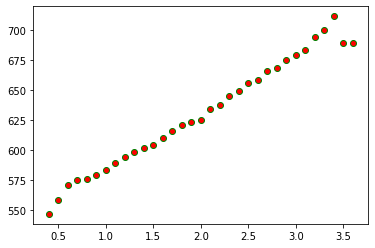

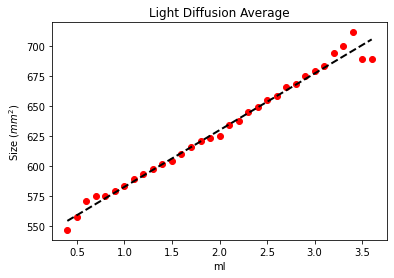

In [53]:
%gui asyncio
import asyncio
import ipywidgets as widgets
import os
import math
import csv
import numpy as np

from datetime import datetime

# Getting the current date and time
dt = datetime.now()
## todo:
# 1. save the contents of the precision buffers into a dataframe
# 2. get the plots to come out separately
# 3. Gather data 
image_dir = "/Users/pierre/Pictures/biology/Blob-Measuring/Level-Measurement-Experiment/stream-captures/"

BUFFER_SIZE = 50
PRECISION_BUFFER_SIZE = 5
camera_name = "camerafluidleveldetect"
progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
buffer_progress = widgets.IntProgress(value=0, min=0, max=BUFFER_SIZE)
buffer_progress.description = "Buffer"
capture_progress = widgets.IntProgress(value=0, min=0, max=PRECISION_BUFFER_SIZE)
capture_progress.description = "Captures"
capture_dataframe = widgets.ToggleButton()
capture_dataframe.description = "get dataframe"
capture_datapoint = widgets.ToggleButton()
capture_datapoint.description = "capture image"
display(capture_datapoint)
display(buffer_progress)
display(capture_progress)
fluid_volume = widgets.Text()
fluid_volume.value = "00"
fluid_volume.description = "filename"
#an int slider widget that sets the value of fluid_volume.value
fluid_value_slider = widgets.IntSlider(value=1, min=1, max=30, step=1)
fluid_value_slider.description = "Increment"


img_folder = widgets.Text()
img_folder.description = "folder"
img_folder.value = dt.strftime("%d-%B-%YT%H:%M:%S")
plot = widgets.ToggleButton()
plot.description = "plot size"

output = widgets.Output()
#a button to create a new folder
dir_button = widgets.Button(description="Create Folder")
#a button widget that creates a directory from the img_folder.value parameter
def create_folder(b):
    with output:
        if img_folder.value is not None:
            if not os.path.exists(image_dir+img_folder.value):
                os.makedirs(image_dir+img_folder.value)
                print("Folder Created")
            else:
                print("Folder already exists")
        else:
            print("Folder not created")

dir_button.on_click(create_folder)

display(fluid_volume)
display(fluid_value_slider)
display(plot)
display(img_folder)
display(dir_button)
display(progress)
display(capture_dataframe)
#display(text_input)
#text.value= str(button.value)

stop_button = widgets.ToggleButton()
stop_button.description = "Stop"
display(stop_button)

display(output)

# a method that returns the mean but rejects outliers from the calculation
def mean_filter(data, threshold):
    data_mean = mean(data)
    data_std = stdev(data)
    data_filtered = [x for x in data if abs(x - data_mean) < threshold * data_std]
    return mean(data_filtered)

async def f():   
    i=0
    size = [[],[],[],[],[],[],[]]
    perimeter_buffer_list = []
    area_buffer_list = []

    perimeter_value_frame = []
    area_value_frame = []
    dataframe_count = 0
    dataframe_total = 100

    perimeter_frame_dict = {}
    area_frame_dict = {}
    area_buffer = []
    area_precision_buff = []
    perimeter_buffer = []
    perimeter_precision_buff = []
    buffer_size = BUFFER_SIZE
    buffer_fill = 0
    first = True

    for i in range(buffer_size):
        area_buffer.append(0)
        perimeter_buffer.append(0)

    stream = urllib.request.urlopen('http://' + camera_name +'.local/html/cam_pic.php')
    bytes = b''
    #os.chdir(image_dir)

    WINDOW_NAME = "Camera"
    cv2.namedWindow(WINDOW_NAME)
    cv2.startWindowThread()
    print("hello")

    #transfer_function_coeffs = [-6.40190835e-05 , 1.00543104e-01 , -3.52312603e+01]
    transfer_function_coeffs = [  0.02130269, -11.15089045]


    while True:
        # grab the frame from the threaded video stream, resize it, and convert it to grayscale
        curr_dt = datetime.now()
        timestamp = int(round(curr_dt.timestamp()))
    #     print("Integer timestamp of current datetime: ",
    #       timestamp)
        bytes += stream.read(1024)
        a = bytes.find(b'\xff\xd8') #frame starting 
        b = bytes.find(b'\xff\xd9') #frame ending
        if a != -1 and b != -1:
            jpg = bytes[a:b+2]
            bytes = bytes[b+2:]
            frame = cv2.imdecode(np.frombuffer(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
            #cv2.imshow('image', img)
            bytes = b''
            url = 'http://' + camera_name +'.local/html/cam_pic.php?' + str(timestamp)
            #print(url)
            stream = urllib.request.urlopen(url)
            #frame = imutils.resize(frame, width=600)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            gray_blurred = cv2.medianBlur(gray,91)
            ret, thresh = cv2.threshold(gray_blurred, 130, 255, cv2.THRESH_BINARY_INV)

            #get contours and fit ellipse
            perimeter = "boof"
            try:
                        #my stuff
                contours,hierarchy = cv2.findContours(thresh, 1, 2)
                threshold_area_min = 5000     #threshold area 
                threshold_area_max = 10000
                contours, hierarchy = cv2.findContours(thresh,1,2)  
                # cnt = contours[0]
                for cntr in contours:        
                    area = cv2.contourArea(cntr)         
                    if area > threshold_area_min and area < threshold_area_max:
                        cnt = cntr
                        area_buffer.pop(0)
                        area_buffer.append(area)
                        break
                # cnt = contours[0]
                # M = cv2.moments(cnt)

                ellipse = cv2.fitEllipse(cnt)
                cv2.ellipse(frame,ellipse,(0,255,0),5)

                (a,b) = ellipse[1]
                perimeter = (2 * 3.14 *
                    sqrt((a * a + b * b) /
                               (2 * 1.0)))
                perimeter_buffer.pop(0)
                perimeter_buffer.append(perimeter)
                buffer_fill += 1

            except Exception as e:
                print(e)
                pass
            buffer_progress.value = min(buffer_fill, buffer_size)
            # Display measured values on frame
   
            font = cv2.FONT_HERSHEY_SIMPLEX
            #org = (50, 50)
            fontScale = 0.5
            color = (0, 136, 17)
            thickness = 1
            # Using cv2.putText() method
#             try:
#                 display_frame = cv2.putText(frame, str(cv2.contourArea(cnt)), (50,100), font, 
#                                     fontScale, color, thickness, cv2.LINE_AA)
#                 display_frame = cv2.putText(display_frame, str(mean(area_buffer)), org, font, 
#                                     fontScale, color, thickness, cv2.LINE_AA)
#                 display_frame = cv2.putText(display_frame, str(stdev(area_buffer)), (300,50), font, 
#                         fontScale, color, thickness, cv2.LINE_AA)
#                 display_frame = cv2.putText(display_frame, str(variance(area_buffer)), (300,100), font, 
#                         fontScale, color, thickness, cv2.LINE_AA)
#             except:
#                 display_frame = cv2.putText(frame, "boof", (50,100), font, 
#                         fontScale, color, thickness, cv2.LINE_AA)
            
            try:
                display_frame = cv2.putText(frame, "per: " + str(round(perimeter,2)), (50,50), font, 
                                    fontScale, color, thickness, cv2.LINE_AA)
                display_frame = cv2.putText(display_frame, "mean: " + str(round(mean(perimeter_buffer),2)), (50,75), font, 
                                    fontScale, color, thickness, cv2.LINE_AA)
                display_frame = cv2.putText(display_frame, "stdev: "+str(round(stdev(perimeter_buffer),2)), (300,50), font, 
                        fontScale, color, thickness, cv2.LINE_AA)
                display_frame = cv2.putText(display_frame, "var: "+ str(round(variance(perimeter_buffer),2)), (300,75), font, 
                        fontScale, color, thickness, cv2.LINE_AA)

                display_frame = cv2.putText(display_frame, "volume estimate: "+ str(round(np.polyval(transfer_function_coeffs, mean(perimeter_buffer)),2)).zfill(6) + " ml", (150,300), font, 
                        fontScale, color, thickness, cv2.LINE_AA)
                        
            except Exception as e:
                print(e)
                display_frame = cv2.putText(frame, "boof", (50,100), font, 
                        fontScale, color, thickness, cv2.LINE_AA)
            #display_frame = frame

            # Display frame on screen
            cv2.imshow(WINDOW_NAME, display_frame)
            key = cv2.waitKey(1) & 0xFF
            # if the 'q' key is pressed, stop the loop
            if key == ord("q"):
                cv2.destroyAllWindows()
                cv2.waitKey(1)
                break
            i += 1
        #text.value = str(i) + " " + str(button.value)

            # After button is pressed, wait for stdev of perimeter to be below a certain threshold
            # if stdev(perimeter_buffer) < 0.5 then capture a datapoint and reset buffer
            if capture_datapoint.value == True:
                #i = 0

                #if first time, buffer_fill = 0
                if first:
                    buffer_fill = 0
                    first = False

                if(stdev(perimeter_buffer) < 1 and buffer_fill >= buffer_size):

                    perimeter_precision_buff.append(mean(perimeter_buffer))
                    area_precision_buff.append(mean(area_buffer))

                    # add area buffer and perimeter buffer to list of lists
                    # buffer_lists[0].append(area_buffer)
                    # buffer_lists[1].append(perimeter_buffer)
                    # print(perimeter_buffer)
                    # print(buffer_lists)
                    # print(buffer_lists[0])
                    # print(buffer_lists[1])
                    perimeter_named_data = [int(fluid_volume.value)/10]
                    perimeter_named_data = perimeter_named_data + perimeter_buffer.copy()
                    perimeter_buffer_list.append(perimeter_named_data.copy())

                    area_named_data = [int(fluid_volume.value)/10]
                    area_named_data = area_named_data + area_buffer.copy()
                    area_buffer_list.append(area_named_data.copy())

                    # list to csv
                    with open(image_dir+img_folder.value+"/"+'area_buffer.csv', 'w') as f:
                        writer = csv.writer(f)
                        writer.writerows(area_buffer_list)
                    with open(image_dir+img_folder.value+"/"+'perimeter_buffer.csv', 'w') as f:
                        writer = csv.writer(f)
                        writer.writerows(perimeter_buffer_list)



                    
                    #reset buffer (effectively)
                    buffer_fill = 0
                    capture_progress.value += 1
                    if capture_progress.value >= int(PRECISION_BUFFER_SIZE):
                        cv2.imwrite(image_dir+img_folder.value + "/" + fluid_volume.value+".jpg",frame)
                        capture_datapoint.value = False
                        first = True
                        capture_progress.value = 0

                        
                        

                        size[0].append(int(fluid_volume.value)/10)
                        size[1].append(perimeter)
                        # size[2].append(mean(perimeter_buffer))
                        # size[3].append(stdev(perimeter_buffer))
                        size[2].append(mean(perimeter_precision_buff))
                        size[3].append(stdev(perimeter_precision_buff))
                        size[4].append(cv2.contourArea(cnt))
                        # size[5].append(mean(area_buffer))
                        # size[6].append(stdev(area_buffer))
                        size[5].append(mean(area_precision_buff))
                        size[6].append(stdev(area_precision_buff))
                        
                        # size[7].append(perimeter_buffer)
                        # size[8].append(area_buffer)

                        perimeter_frame_dict[fluid_volume.value] = perimeter_precision_buff
                        perimeter_precision_buff = []
                        area_frame_dict[fluid_volume.value] = area_precision_buff
                        area_precision_buff = []
                        df = pd.DataFrame(perimeter_frame_dict)
                        df.to_csv(image_dir+img_folder.value+"/"+'perimeter_dataframe.csv')
                        df = pd.DataFrame(area_frame_dict)
                        df.to_csv(image_dir+img_folder.value+"/"+'area_dataframe.csv')

                        fluid_volume.value = str(int(fluid_volume.value)+fluid_value_slider.value).zfill(2)
                # capture_dataframe.value = True
            await asyncio.sleep(0.001)
            
            if capture_dataframe.value == True:
                perimeter_value_frame.append(perimeter)
                area_value_frame.append(cv2.contourArea(cnt))
                dataframe_count += 1
                progress.value = float(dataframe_count+1)/dataframe_total
                if dataframe_count >= dataframe_total:
                    capture_dataframe.value = False
                    dataframe_count = 0

                    #fill frames with data
                    perimeter_frame_dict[fluid_volume.value] = perimeter_value_frame
                    perimeter_value_frame = []
                    area_frame_dict[fluid_volume.value] = area_value_frame
                    area_value_frame = []
                    df = pd.DataFrame(perimeter_frame_dict)
                    df.to_csv(image_dir+img_folder.value+"/"+'perimeter_dataframe.csv')
                    df = pd.DataFrame(area_frame_dict)
                    df.to_csv(image_dir+img_folder.value+"/"+'area_dataframe.csv')
                    
                
                
            if plot.value == True:
                print(size)
                plot.value = False
                dict = {"volume" : size[0] , "perimeter" : size[1], "perimeter_pb_mean" : size[2],"perimeter_pb_stdev" : size[3], "contour_area" : size[4], "contour_area_pb_mean":size[5], "contour_area_pb_stdev":size[6]}
                df = pd.DataFrame(dict) 
                # saving the dataframe 
                df.to_csv(image_dir+img_folder.value+"/"+'all_values.csv') 

                
                try:
                    fig, ax = plt.subplots()
                    ax.errorbar(size[0], size[2], yerr=size[3],fmt="o", mfc='red',
                            mec='green')#, ms=20, mew=4)
                    # plt.title("Light Diffusion Average")
                    # plt.show
                    # plt.plot(size[0],size[1], 'ro')
                    # x= size[0]
                    # y=size[1]
                    # z = np.polyfit(x, y, 3)
                    # p = np.poly1d(z)
                    # plt.plot(x,p(x),'k--',linewidth=2)
                    # color = 0.8
                    # plt.ylabel('Size ($mm^2$)')
                    # plt.xlabel('ml')
                    # plt.title("Light Diffusion")
                    # plt.show()
                    fig2, ax2 = plt.subplots()
                    ax2.plot(size[0],size[2], 'ro')
                    x=size[0]
                    y=size[1]
                    z = np.polyfit(x, y,1)
                    p = np.poly1d(z)
                    ax2.plot(x,p(x),'k--',linewidth=2)
                    color = 0.8
                    ax2.set_ylabel('Size ($mm^2$)')
                    ax2.set_xlabel('ml')
                    ax2.set_title("Light Diffusion Average")
                    plt.show()
                    #print( "y=%.6fx+(%.6f)"%(z[0],z[1]))

                    
                except Exception as e:
                    print(e)
                    pass
                
            if stop_button.value == True:
                cv2.destroyAllWindows()
                cv2.waitKey(1)
                return
        
asyncio.create_task(f())
# if we are not using a video file, stop the camera video stream
# if not args.get("video", False):
#     vs.stop()
# # otherwise, release the camera
# else:
#     vs.release()
# # close all windows
# cv2.destroyAllWindows()


In [ ]:
import cv2
import urllib.request
import numpy as np
from datetime import datetime

stream = urllib.request.urlopen('http://camerag11.local/html/cam_pic.php')
bytes = b''
while True:
    

    curr_dt = datetime.now()
    timestamp = int(round(curr_dt.timestamp()))

#     print("Integer timestamp of current datetime: ",
#       timestamp)
    bytes += stream.read(1024)
    a = bytes.find(b'\xff\xd8') #frame starting 
    b = bytes.find(b'\xff\xd9') #frame ending
    if a != -1 and b != -1:
        jpg = bytes[a:b+2]
        bytes = bytes[b+2:]
        img = cv2.imdecode(np.frombuffer(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
        cv2.imshow('image', img)
        bytes = b''
        url = 'http://camerag11.local/html/cam_pic.php?' + str(timestamp)
        print(url)
        stream = urllib.request.urlopen(url)
        
        if cv2.waitKey(1) == 27:
            cv2.destroyAllWindows()
            break

In [ ]:
%gui asyncio
import asyncio
import ipywidgets as widgets

button = widgets.ToggleButton()
display(button)
text = widgets.Text()
text_input = widgets.Text()
display(text)
display(text_input)
text.value= str(button.value)

stop_button = widgets.ToggleButton()
stop_button.description = "Stop"
display(stop_button)

async def f():   
    i=0
    while True:
        i += 1
        #text.value = str(i) + " " + str(button.value)
        if button.value == True:
            i = 0
            button.value = False
            text.value = text_input.value
        await asyncio.sleep(0.001)
        if stop_button.value == True:
            return

asyncio.create_task(f());